# LoFtr type Transformer for delay heatmap prediction

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, accuracy_score, mean_absolute_error

2024-10-01 08:03:42.363333: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-01 08:03:42.615405: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-01 08:03:43.369167: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.3/lib64:/usr/include/opencv4
2024-10-01 08:03:43.371030: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvi

In [2]:
# extracted feature
trainDS = np.load("/home/jireh/MT/video_sync_v1/trash/featureData_21.npy",allow_pickle=True)
print(trainDS[0][0].shape)

# Convert to a pandas DataFrame 
df = pd.DataFrame(trainDS)
# Display the first few rows: (left_feature, right_feature, left_id, right_id, delay)
df.head()

(20, 48)


,0,1,2,3,4
0,"[[0.0, 0.0, 0.0, 2.0682578, 0.0, 0.0, 0.0, 0.1...","[[0.0, 0.0, 0.0, 2.0747275, 0.0, 0.0, 0.0, 0.4...",4610,4607,-3
1,"[[0.0, 0.0, 0.0, 1.2676319, 0.0, 0.0, 0.0, 0.9...","[[0.0, 0.0, 0.0, 1.4032005, 0.0, 0.0, 0.0, 0.8...",5170,5186,16
2,"[[0.0, 0.0, 0.0, 1.8297346, 0.0, 0.0, 0.0, 0.6...","[[0.0, 0.0, 0.0, 0.75910074, 0.0, 0.0, 0.0, 1....",1496,1513,17
3,"[[0.0, 0.0, 0.0, 1.8516473, 0.0, 0.0, 0.0, 0.6...","[[0.0, 0.0, 0.0, 1.5452933, 0.0, 0.0, 0.0, 0.8...",8661,8649,-12
4,"[[0.0, 0.0, 0.0, 1.9564884, 0.0, 0.0, 0.0, 0.3...","[[0.0, 0.0, 0.0, 1.9525297, 0.0, 0.0, 0.0, 0.8...",2506,2517,11


In [24]:
class PredictionCallback(Callback):
    def __init__(self, val_data):
        super(PredictionCallback, self).__init__()
        self.val_data = val_data

    def on_train_end(self, logs=None):

        # model testing
        val_pred_all = []
        val_true_all = []

        # Loop through the entire validation dataset
        for batch in self.val_data:
            inputs, y_true = batch
            y_pred = self.model.predict(inputs)
            for i in range(y_true.shape[0]):
                distance, _ = self.find_largest_diag(y_pred[i])
                val_pred_all.append(distance)
                distance, _ = self.find_largest_diag(y_true[i])
                val_true_all.append(distance)

        # Display final predictions for the first 30 samples
        print("\nFinal predictions after training:")
        print("Predicted:", val_pred_all[:30])
        print("True:", val_true_all[:30])

        # f1 score, accuracy, mae
        f1 = f1_score(val_true_all, val_pred_all, average='weighted')
        acc = accuracy_score(val_true_all, val_pred_all)
        mae = mean_absolute_error(val_true_all, val_pred_all)

        print(f"accuracy in total: {acc}")
        print(f"f1 score: {f1}")
        print(f"mean absolute error: {mae}")

        # Take the first batch of validation samples at the end of training
        for batch in self.val_data.take(1):
            inputs, y_true = batch
            y_pred = self.model.predict(inputs)

            # Print final predictions and corresponding true values after training
            print("\nheatmap visualization:")
            distance, heatmap = self.find_largest_diag(y_pred[0])

            # Plot the heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_pred[0], annot=True, cmap="coolwarm")
            plt.title(f'predition: {distance}')
            plt.show()

            plt.figure(figsize=(20, 20))
            sns.heatmap(heatmap, annot=True, cmap="coolwarm")
            plt.title('predition heatmap (row and column maxima)')
            plt.show()

            plt.figure(figsize=(20, 20))
            sns.heatmap(y_true[0], annot=True, cmap="coolwarm")
            plt.title('True Labels Heatmap')
            plt.show()

    def find_largest_diag(self, similarity_matrix):
        # Get matrix dimensions
        n = similarity_matrix.shape[0]

        # Convert to TensorFlow tensor
        sim_matrix = tf.constant(similarity_matrix, dtype=tf.float32)

        # Find the position of the maximum value in each row
        row_max_indices = []
        for i in range(n):
            row_idx = tf.argmax(sim_matrix[i, :])
            row_max_indices.append(tf.round(row_idx))  # Round the softargmax result to integer index
        row_max_indices = tf.stack(row_max_indices)
#         print("Row max indices (rounded):", row_max_indices)

        # Find the position of the maximum value in each column
        col_max_indices = []
        for i in range(n):
            col_idx = tf.argmax(sim_matrix[:, i])
            col_max_indices.append(tf.round(col_idx))  # Similarly, round each column result
        col_max_indices = tf.stack(col_max_indices)
#         print("Column max indices (rounded):", col_max_indices)

        # Create a heatmap to mark the maximum values
        heatmap = np.zeros_like(similarity_matrix)
        for i in range(n):
            row_idx = int(row_max_indices[i].numpy())
            col_idx = int(col_max_indices[i].numpy())

            # Ensure indices are within matrix dimensions
            if 0 <= row_idx < n:
                heatmap[i, row_idx] += 1  # Mark the maximum value in each row
            if 0 <= col_idx < n:
                heatmap[col_idx, i] += 1  # Mark the maximum value in each column

        # Find the diagonal with the most marks
        max_diag_marks = -1
        max_diag_idx = 0
        for diag_idx in range(-n + 1, n):
            diag_marks = np.sum(np.diag(heatmap, k=diag_idx))
            if diag_marks > max_diag_marks:
                max_diag_marks = diag_marks
                max_diag_idx = diag_idx

        # Calculate the distance of the optimal diagonal from the center diagonal
        distance = max_diag_idx

        # Return the distance and the heatmap
        return distance, heatmap

In [27]:
def get_positional_encoding(seq_len, embed_dim):
    """
    Generates the positional encoding matrix for the input sequence.
    Args:
        seq_len (int): The length of the input sequence.
        embed_dim (int): The embedding dimension.
    Returns:
        tf.Tensor: A tensor containing positional encodings.
    """
    position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # Shape (seq_len, 1)
    div_term = tf.exp(
        tf.range(0, embed_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embed_dim))  # Shape (embed_dim//2,)

    pos_enc = tf.zeros((seq_len, embed_dim))

    # Apply sin to even indices
    pos_enc = pos_enc + tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)

    return pos_enc

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, nhead):
        super(EncoderLayer, self).__init__()

        self.nhead = nhead

        self.q_proj = layers.Dense(d_model, use_bias=False)
        self.k_proj = layers.Dense(d_model, use_bias=False)
        self.v_proj = layers.Dense(d_model, use_bias=False)
        self.attention = layers.MultiHeadAttention(num_heads=self.nhead, key_dim=d_model)
        self.merge = layers.Dense(d_model, use_bias=False)

        # feed-forward network
        self.mlp = tf.keras.Sequential([
            layers.Dense(d_model * 2, use_bias=False),
            layers.ReLU(),
            layers.Dense(d_model, use_bias=False)
        ])

        # norm layers
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()

    def call(self, x, source):
        # multi-head attention
        query = self.q_proj(x)
        key = self.k_proj(source)
        value = self.v_proj(source)

        message = self.attention(query=query, key=key, value=value)
        message = self.merge(message)
        message = self.norm1(message)

        # feed-forward network
        message = self.mlp(tf.concat([x, message], axis=-1))
        message = self.norm2(message)

        return x + message

In [28]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads=4, embed_dim=48, num_layers=2):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim

        # Transformer Encoder layers (Now using cross-attention)
        self.encoder_layers = [
            EncoderLayer(d_model=embed_dim, nhead=num_heads)
            for _ in range(num_layers * 2)
        ]

        self.multiHeadattention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=self.embed_dim)

    def call(self, inputs, training=True):
        query = inputs['query']
        context = inputs['context']
        batch_size = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]

        # Incorporate positional encoding
        self.positional_encoding = get_positional_encoding(seq_len, self.embed_dim)

        # Add positional encoding to query and context after concatenating the class token
        query += self.positional_encoding[:seq_len, :]  # Adding positional encoding for sequence
        context += self.positional_encoding[:seq_len, :]

        # Pass through transformer encoder layers using cross-attention
        for i, encoder_layer in enumerate(self.encoder_layers):
            if i % 2 == 0:
                # self-attention
                query = encoder_layer(query, query)
                context = encoder_layer(context, context)

            else:
                # cross-attention
                query = encoder_layer(query, context)
                context = encoder_layer(context, query)

        _, attention_scores = self.multiHeadattention(query=query, key=context, value=context,
                                                      return_attention_scores=True)

        similarity_matrix = tf.reduce_mean(attention_scores, axis=1)

        return similarity_matrix

    def train(self, pathSimilarityVectorsArray: str, batch_size=256, epochs=100, learning_rate=1e-3, weight_name=""):
        """
        Args:
            train_dataset (tf.data.Dataset): Training dataset.
            val_dataset (tf.data.Dataset): Validation dataset.
            epochs (int): Number of epochs to train for.
            learning_rate (float): Learning rate for the optimizer.
            train_steps_per_epoch (int): Number of training steps per epoch.
            val_steps_per_epoch (int): Number of validation steps per epoch.
        """

        def create_diag_matrix(y, sequence_length):
            matrix = np.zeros((sequence_length, sequence_length), dtype=np.float32)
            diag_offset = int(y)
            if -sequence_length < diag_offset < sequence_length:
                effective_length = max(0, sequence_length - abs(diag_offset))
                if effective_length > 0:
                    np.fill_diagonal(matrix[max(0, -diag_offset):, max(0, diag_offset):], 1)
            return matrix

        def map_fn(features, y_label):
            sequence_length = 20
            diag_matrix = tf.py_function(func=create_diag_matrix, inp=[y_label, sequence_length], Tout=tf.float32)
            diag_matrix.set_shape((sequence_length, sequence_length))
            return features, diag_matrix

        trainDS = np.load(fr"{pathSimilarityVectorsArray}", allow_pickle=True)

        # Extracting the features and labels from the training dataset
        left_features = trainDS[:, 0].tolist()
        right_features = trainDS[:, 1].tolist()
        y = trainDS[:, 4].tolist()

        # Convert lists to numpy arrays and then to tensors
        left_features = np.array(left_features)
        right_features = np.array(right_features)
        y = np.array(y).astype(np.float32)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)

        # Split the dataset into training and validation sets
        size = int(len(y) * 0.8)  # Use 80% of the data for training
        left_features_train, left_features_val = left_features[:size], left_features[size:]
        right_features_train, right_features_val = right_features[:size], right_features[size:]
        y_train, y_val = y[:size], y[size:]

        # Creating TensorFlow datasets without preprocessing labels in advance
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features_train, 'context': right_features_train}, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024)

        # Use a map function to convert y to diagonal matrices
        train_dataset = train_dataset.map(map_fn).batch(batch_size, drop_remainder=True).repeat()

        # Construct the validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices(
            ({'query': left_features_val, 'context': right_features_val}, y_val))
        val_dataset = val_dataset.map(map_fn).batch(128, drop_remainder=True)

        # Calculate the number of training and validation steps per epoch
        train_steps_per_epoch = len(left_features_train) // batch_size
        val_steps_per_epoch = len(left_features_val) // 128

        # Add ModelCheckpoint to save only the weights of the best model
        checkpoint_callback = ModelCheckpoint(
            weight_name,  # Save only the model weights
            monitor='val_loss',  # Monitor validation accuracy
            save_best_only=True,  # Save only if the validation accuracy improves
            mode='min',  # We want to maximize the validation accuracy
            save_weights_only=True,  # Save only the weights, not the entire model
            verbose=1
        )

        # Compile the model using the custom loss function
        optimizer = Adam(learning_rate=1e-3)
        self.compile(optimizer=optimizer, loss=self.rows_cols_crossentropyLoss)

        # Train the model with the specified datasets, number of epochs, and callbacks
        model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=train_steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=val_steps_per_epoch,
            callbacks=[checkpoint_callback, PredictionCallback(val_dataset)]
        )

        # Load the best model weights at the end of training
        self.load_weights(weight_name)

    def rows_cols_crossentropyLoss(self, y_true, y_pred):
        # Row-wise softmax
        y_pred_row_softmax = tf.nn.softmax(y_pred, axis=-1)  # Softmax along rows (axis=-1)
        # Column-wise softmax
        y_pred_col_softmax = tf.nn.softmax(y_pred, axis=-2)  # Softmax along columns (axis=-2)

        # Generate row mask (if a row in y_true is all zeros, mask it out)
        row_mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, seq_len)
        row_mask = tf.cast(row_mask, dtype=tf.float32)  # Convert bool mask to float (1s and 0s)

        # Row-wise cross-entropy loss (batch-wise operation)
        row_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred_row_softmax)
        row_loss = row_loss * row_mask  # Apply the mask to the row loss

        # Transpose y_true and y_pred for column-wise loss (only last two dimensions)
        y_true_transposed = tf.transpose(y_true, perm=[0, 2, 1])  # Swap last two dimensions for batched input
        y_pred_col_softmax_transposed = tf.transpose(y_pred_col_softmax, perm=[0, 2, 1])

        # Generate column mask (if a column in y_true is all zeros, mask it out)
        col_mask = tf.reduce_sum(y_true, axis=-2) > 0  # Shape: (batch_size, seq_len)
        col_mask = tf.cast(col_mask, dtype=tf.float32)  # Convert bool mask to float (1s and 0s)

        # Column-wise cross-entropy loss
        col_loss = tf.keras.losses.categorical_crossentropy(y_true_transposed, y_pred_col_softmax_transposed)
        col_loss = col_loss * col_mask  # Apply the mask to the column loss

        # Final loss is the average of row and column losses (only summing valid rows and columns)
        total_loss = (tf.reduce_sum(row_loss) + tf.reduce_sum(col_loss)) / (
                    tf.reduce_sum(row_mask) + tf.reduce_sum(col_mask))

        return total_loss


Model Parameters:
Number of heads: 4
Embedding dimension: 48
Number of layers: 2
Learning rate: 0.001
Weight name: best_weights_org.h5
Epoch 1/400
93/93 [==============================] - ETA: 0s - loss: 2.9957
Epoch 1: val_loss improved from inf to 2.99569, saving model to best_weights_org.h5
93/93 [==============================] - 68s 668ms/step - loss: 2.9957 - val_loss: 2.9957
Epoch 2/400
93/93 [==============================] - ETA: 0s - loss: 2.9745
Epoch 2: val_loss improved from 2.99569 to 2.94563, saving model to best_weights_org.h5
93/93 [==============================] - 60s 647ms/step - loss: 2.9745 - val_loss: 2.9456
Epoch 3/400
93/93 [==============================] - ETA: 0s - loss: 2.9394
Epoch 3: val_loss improved from 2.94563 to 2.93124, saving model to best_weights_org.h5
93/93 [==============================] - 60s 651ms/step - loss: 2.9394 - val_loss: 2.9312
Epoch 4/400
93/93 [==============================] - ETA: 0s - loss: 2.9297
Epoch 4: val_loss improved from

Epoch 64/400
93/93 [==============================] - ETA: 0s - loss: 2.3954
Epoch 64: val_loss did not improve from 2.40425
93/93 [==============================] - 60s 645ms/step - loss: 2.3954 - val_loss: 2.4201
Epoch 65/400
93/93 [==============================] - ETA: 0s - loss: 2.3984
Epoch 65: val_loss did not improve from 2.40425
93/93 [==============================] - 60s 646ms/step - loss: 2.3984 - val_loss: 2.4078
Epoch 66/400
93/93 [==============================] - ETA: 0s - loss: 2.4031
Epoch 66: val_loss did not improve from 2.40425
93/93 [==============================] - 60s 642ms/step - loss: 2.4031 - val_loss: 2.4116
Epoch 67/400
93/93 [==============================] - ETA: 0s - loss: 2.3907
Epoch 67: val_loss improved from 2.40425 to 2.39725, saving model to best_weights_org.h5
93/93 [==============================] - 60s 647ms/step - loss: 2.3907 - val_loss: 2.3972
Epoch 68/400
93/93 [==============================] - ETA: 0s - loss: 2.3886
Epoch 68: val_loss imp

Epoch 99/400
93/93 [==============================] - ETA: 0s - loss: 2.3148
Epoch 99: val_loss improved from 2.32979 to 2.32357, saving model to best_weights_org.h5
93/93 [==============================] - 62s 664ms/step - loss: 2.3148 - val_loss: 2.3236
Epoch 100/400
93/93 [==============================] - ETA: 0s - loss: 2.3108
Epoch 100: val_loss improved from 2.32357 to 2.32191, saving model to best_weights_org.h5
93/93 [==============================] - 61s 660ms/step - loss: 2.3108 - val_loss: 2.3219
Epoch 101/400
93/93 [==============================] - ETA: 0s - loss: 2.3066
Epoch 101: val_loss improved from 2.32191 to 2.31335, saving model to best_weights_org.h5
93/93 [==============================] - 61s 656ms/step - loss: 2.3066 - val_loss: 2.3133
Epoch 102/400
93/93 [==============================] - ETA: 0s - loss: 2.3078
Epoch 102: val_loss did not improve from 2.31335
93/93 [==============================] - 63s 679ms/step - loss: 2.3078 - val_loss: 2.3300
Epoch 103/4

93/93 [==============================] - 60s 650ms/step - loss: 2.2527 - val_loss: 2.2711
Epoch 135/400
93/93 [==============================] - ETA: 0s - loss: 2.2740
Epoch 135: val_loss did not improve from 2.27111
93/93 [==============================] - 60s 647ms/step - loss: 2.2740 - val_loss: 2.3181
Epoch 136/400
93/93 [==============================] - ETA: 0s - loss: 2.2895
Epoch 136: val_loss did not improve from 2.27111
93/93 [==============================] - 60s 651ms/step - loss: 2.2895 - val_loss: 2.2889
Epoch 137/400
93/93 [==============================] - ETA: 0s - loss: 2.2625
Epoch 137: val_loss improved from 2.27111 to 2.26554, saving model to best_weights_org.h5
93/93 [==============================] - 60s 650ms/step - loss: 2.2625 - val_loss: 2.2655
Epoch 138/400
93/93 [==============================] - ETA: 0s - loss: 2.2509
Epoch 138: val_loss improved from 2.26554 to 2.26112, saving model to best_weights_org.h5
93/93 [==============================] - 60s 648ms

93/93 [==============================] - 60s 650ms/step - loss: 2.2125 - val_loss: 2.2234
Epoch 207/400
93/93 [==============================] - ETA: 0s - loss: 2.2138
Epoch 207: val_loss did not improve from 2.22343
93/93 [==============================] - 61s 657ms/step - loss: 2.2138 - val_loss: 2.2284
Epoch 208/400
93/93 [==============================] - ETA: 0s - loss: 2.2267
Epoch 208: val_loss did not improve from 2.22343
93/93 [==============================] - 60s 650ms/step - loss: 2.2267 - val_loss: 2.2444
Epoch 209/400
93/93 [==============================] - ETA: 0s - loss: 2.2326
Epoch 209: val_loss did not improve from 2.22343
93/93 [==============================] - 62s 670ms/step - loss: 2.2326 - val_loss: 2.2418
Epoch 210/400
93/93 [==============================] - ETA: 0s - loss: 2.2297
Epoch 210: val_loss did not improve from 2.22343
93/93 [==============================] - 60s 650ms/step - loss: 2.2297 - val_loss: 2.2512
Epoch 211/400
93/93 [=====================

93/93 [==============================] - ETA: 0s - loss: 2.1963
Epoch 243: val_loss did not improve from 2.21261
93/93 [==============================] - 61s 652ms/step - loss: 2.1963 - val_loss: 2.2182
Epoch 244/400
93/93 [==============================] - ETA: 0s - loss: 2.1966
Epoch 244: val_loss did not improve from 2.21261
93/93 [==============================] - 60s 651ms/step - loss: 2.1966 - val_loss: 2.2176
Epoch 245/400
93/93 [==============================] - ETA: 0s - loss: 2.2057
Epoch 245: val_loss improved from 2.21261 to 2.21189, saving model to best_weights_org.h5
93/93 [==============================] - 61s 653ms/step - loss: 2.2057 - val_loss: 2.2119
Epoch 246/400
93/93 [==============================] - ETA: 0s - loss: 2.2234
Epoch 246: val_loss did not improve from 2.21189
93/93 [==============================] - 60s 645ms/step - loss: 2.2234 - val_loss: 2.2191
Epoch 247/400
93/93 [==============================] - ETA: 0s - loss: 2.2095
Epoch 247: val_loss did not

Epoch 280/400
93/93 [==============================] - ETA: 0s - loss: 2.2068
Epoch 280: val_loss did not improve from 2.20223
93/93 [==============================] - 60s 648ms/step - loss: 2.2068 - val_loss: 2.2158
Epoch 281/400
93/93 [==============================] - ETA: 0s - loss: 2.1971
Epoch 281: val_loss did not improve from 2.20223
93/93 [==============================] - 60s 651ms/step - loss: 2.1971 - val_loss: 2.2105
Epoch 282/400
93/93 [==============================] - ETA: 0s - loss: 2.1927
Epoch 282: val_loss did not improve from 2.20223
93/93 [==============================] - 60s 649ms/step - loss: 2.1927 - val_loss: 2.2067
Epoch 283/400
93/93 [==============================] - ETA: 0s - loss: 2.2039
Epoch 283: val_loss did not improve from 2.20223
93/93 [==============================] - 61s 653ms/step - loss: 2.2039 - val_loss: 2.2066
Epoch 284/400
93/93 [==============================] - ETA: 0s - loss: 2.1914
Epoch 284: val_loss did not improve from 2.20223
93/93

Epoch 317/400
93/93 [==============================] - ETA: 0s - loss: 2.2130
Epoch 317: val_loss did not improve from 2.19334
93/93 [==============================] - 60s 649ms/step - loss: 2.2130 - val_loss: 2.2140
Epoch 318/400
93/93 [==============================] - ETA: 0s - loss: 2.1882
Epoch 318: val_loss did not improve from 2.19334
93/93 [==============================] - 60s 646ms/step - loss: 2.1882 - val_loss: 2.1977
Epoch 319/400
93/93 [==============================] - ETA: 0s - loss: 2.1887
Epoch 319: val_loss did not improve from 2.19334
93/93 [==============================] - 60s 650ms/step - loss: 2.1887 - val_loss: 2.2098
Epoch 320/400
93/93 [==============================] - ETA: 0s - loss: 2.1822
Epoch 320: val_loss did not improve from 2.19334
93/93 [==============================] - 60s 645ms/step - loss: 2.1822 - val_loss: 2.1975
Epoch 321/400
93/93 [==============================] - ETA: 0s - loss: 2.1774
Epoch 321: val_loss did not improve from 2.19334
93/93

Epoch 354/400
93/93 [==============================] - ETA: 0s - loss: 2.1857
Epoch 354: val_loss did not improve from 2.18880
93/93 [==============================] - 60s 644ms/step - loss: 2.1857 - val_loss: 2.1983
Epoch 355/400
93/93 [==============================] - ETA: 0s - loss: 2.2083
Epoch 355: val_loss did not improve from 2.18880
93/93 [==============================] - 60s 648ms/step - loss: 2.2083 - val_loss: 2.3534
Epoch 356/400
93/93 [==============================] - ETA: 0s - loss: 2.2919
Epoch 356: val_loss did not improve from 2.18880
93/93 [==============================] - 60s 644ms/step - loss: 2.2919 - val_loss: 2.2590
Epoch 357/400
93/93 [==============================] - ETA: 0s - loss: 2.2278
Epoch 357: val_loss did not improve from 2.18880
93/93 [==============================] - 60s 647ms/step - loss: 2.2278 - val_loss: 2.2262
Epoch 358/400
93/93 [==============================] - ETA: 0s - loss: 2.2037
Epoch 358: val_loss did not improve from 2.18880
93/93

93/93 [==============================] - 60s 648ms/step - loss: 2.1729 - val_loss: 2.1890
Epoch 392/400
93/93 [==============================] - ETA: 0s - loss: 2.1727
Epoch 392: val_loss improved from 2.18238 to 2.18179, saving model to best_weights_org.h5
93/93 [==============================] - 60s 647ms/step - loss: 2.1727 - val_loss: 2.1818
Epoch 393/400
93/93 [==============================] - ETA: 0s - loss: 2.1668
Epoch 393: val_loss did not improve from 2.18179
93/93 [==============================] - 60s 647ms/step - loss: 2.1668 - val_loss: 2.2031
Epoch 394/400
93/93 [==============================] - ETA: 0s - loss: 2.2523
Epoch 394: val_loss did not improve from 2.18179
93/93 [==============================] - 60s 644ms/step - loss: 2.2523 - val_loss: 2.2864
Epoch 395/400
93/93 [==============================] - ETA: 0s - loss: 2.2288
Epoch 395: val_loss did not improve from 2.18179
93/93 [==============================] - 60s 647ms/step - loss: 2.2288 - val_loss: 2.2108
E

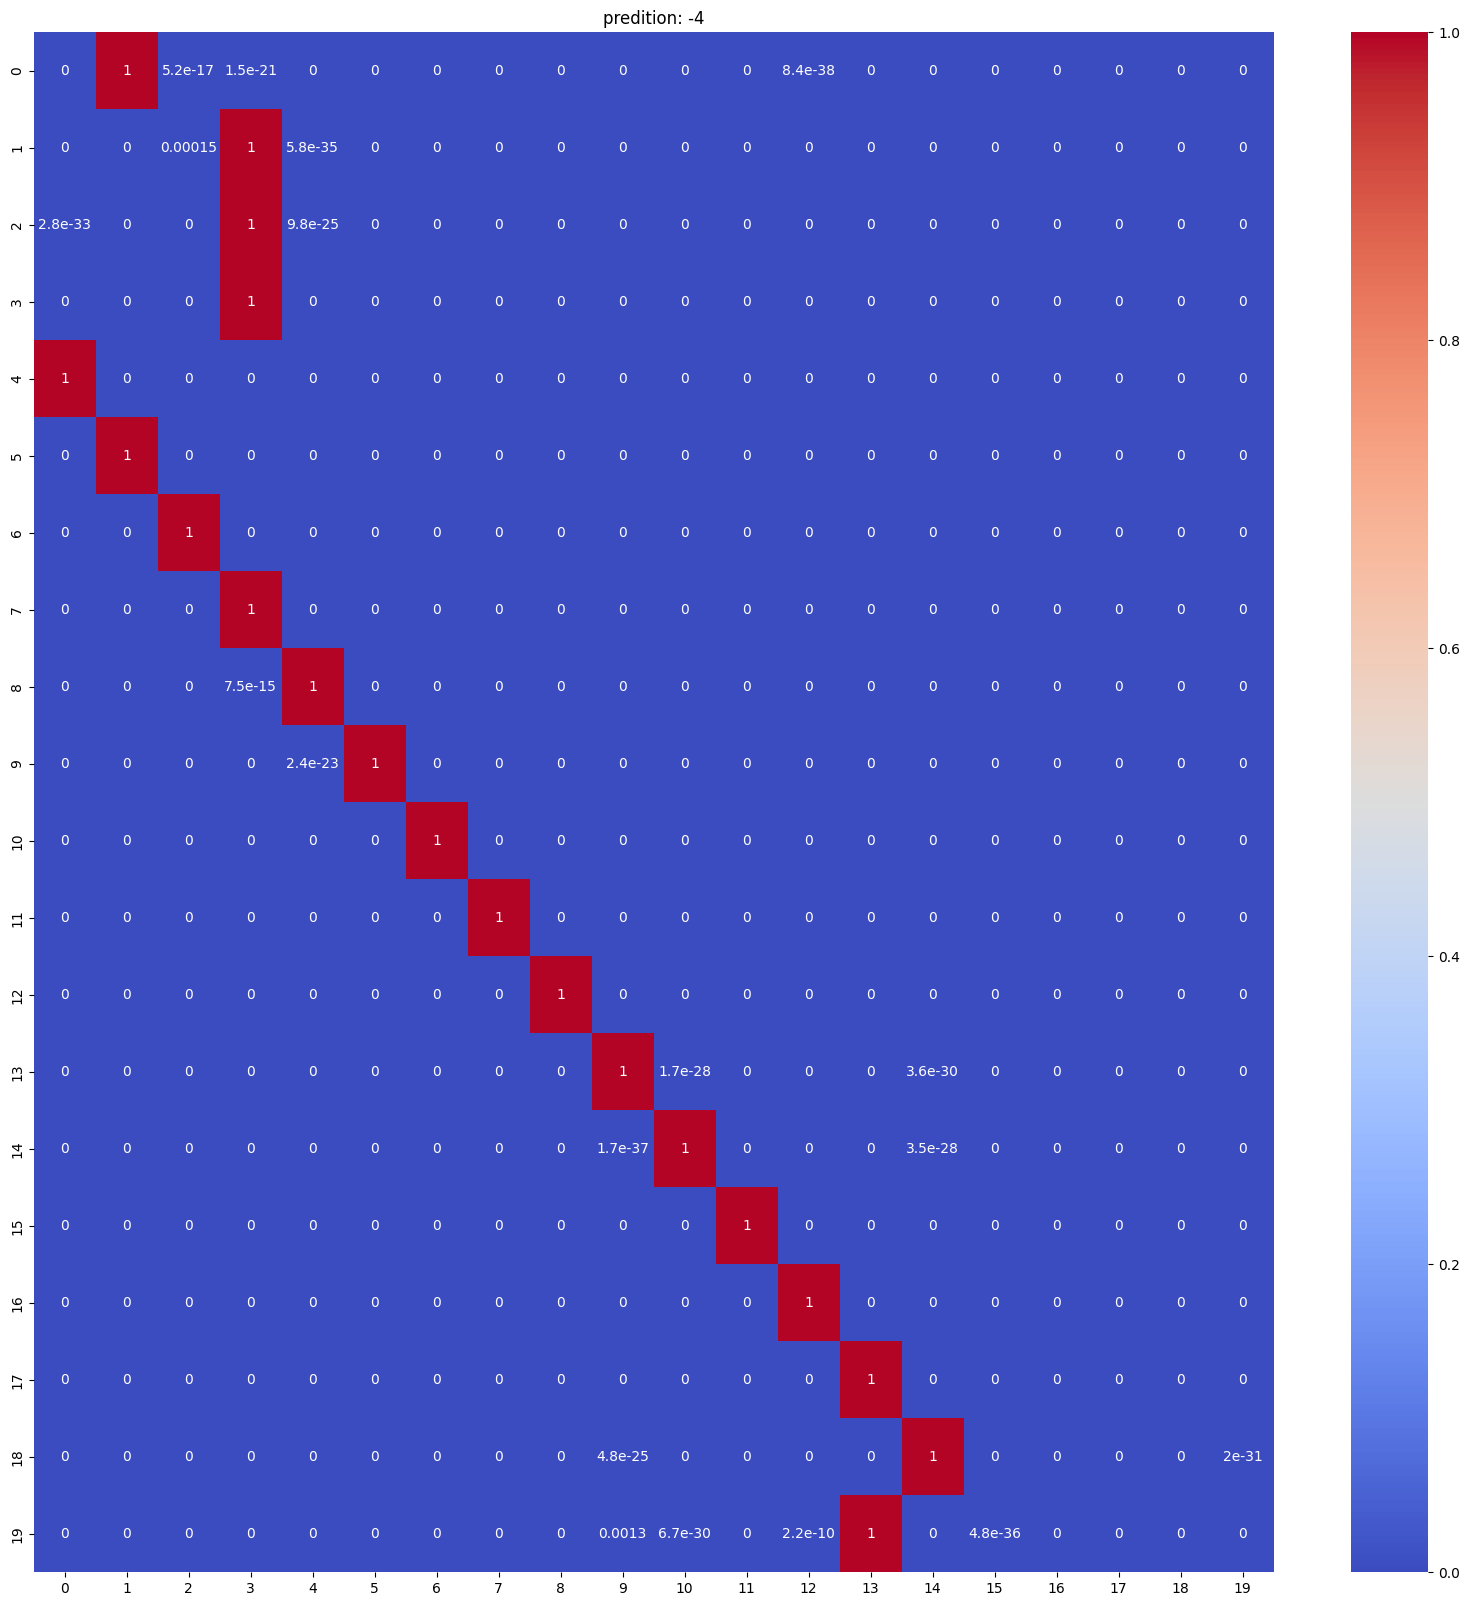

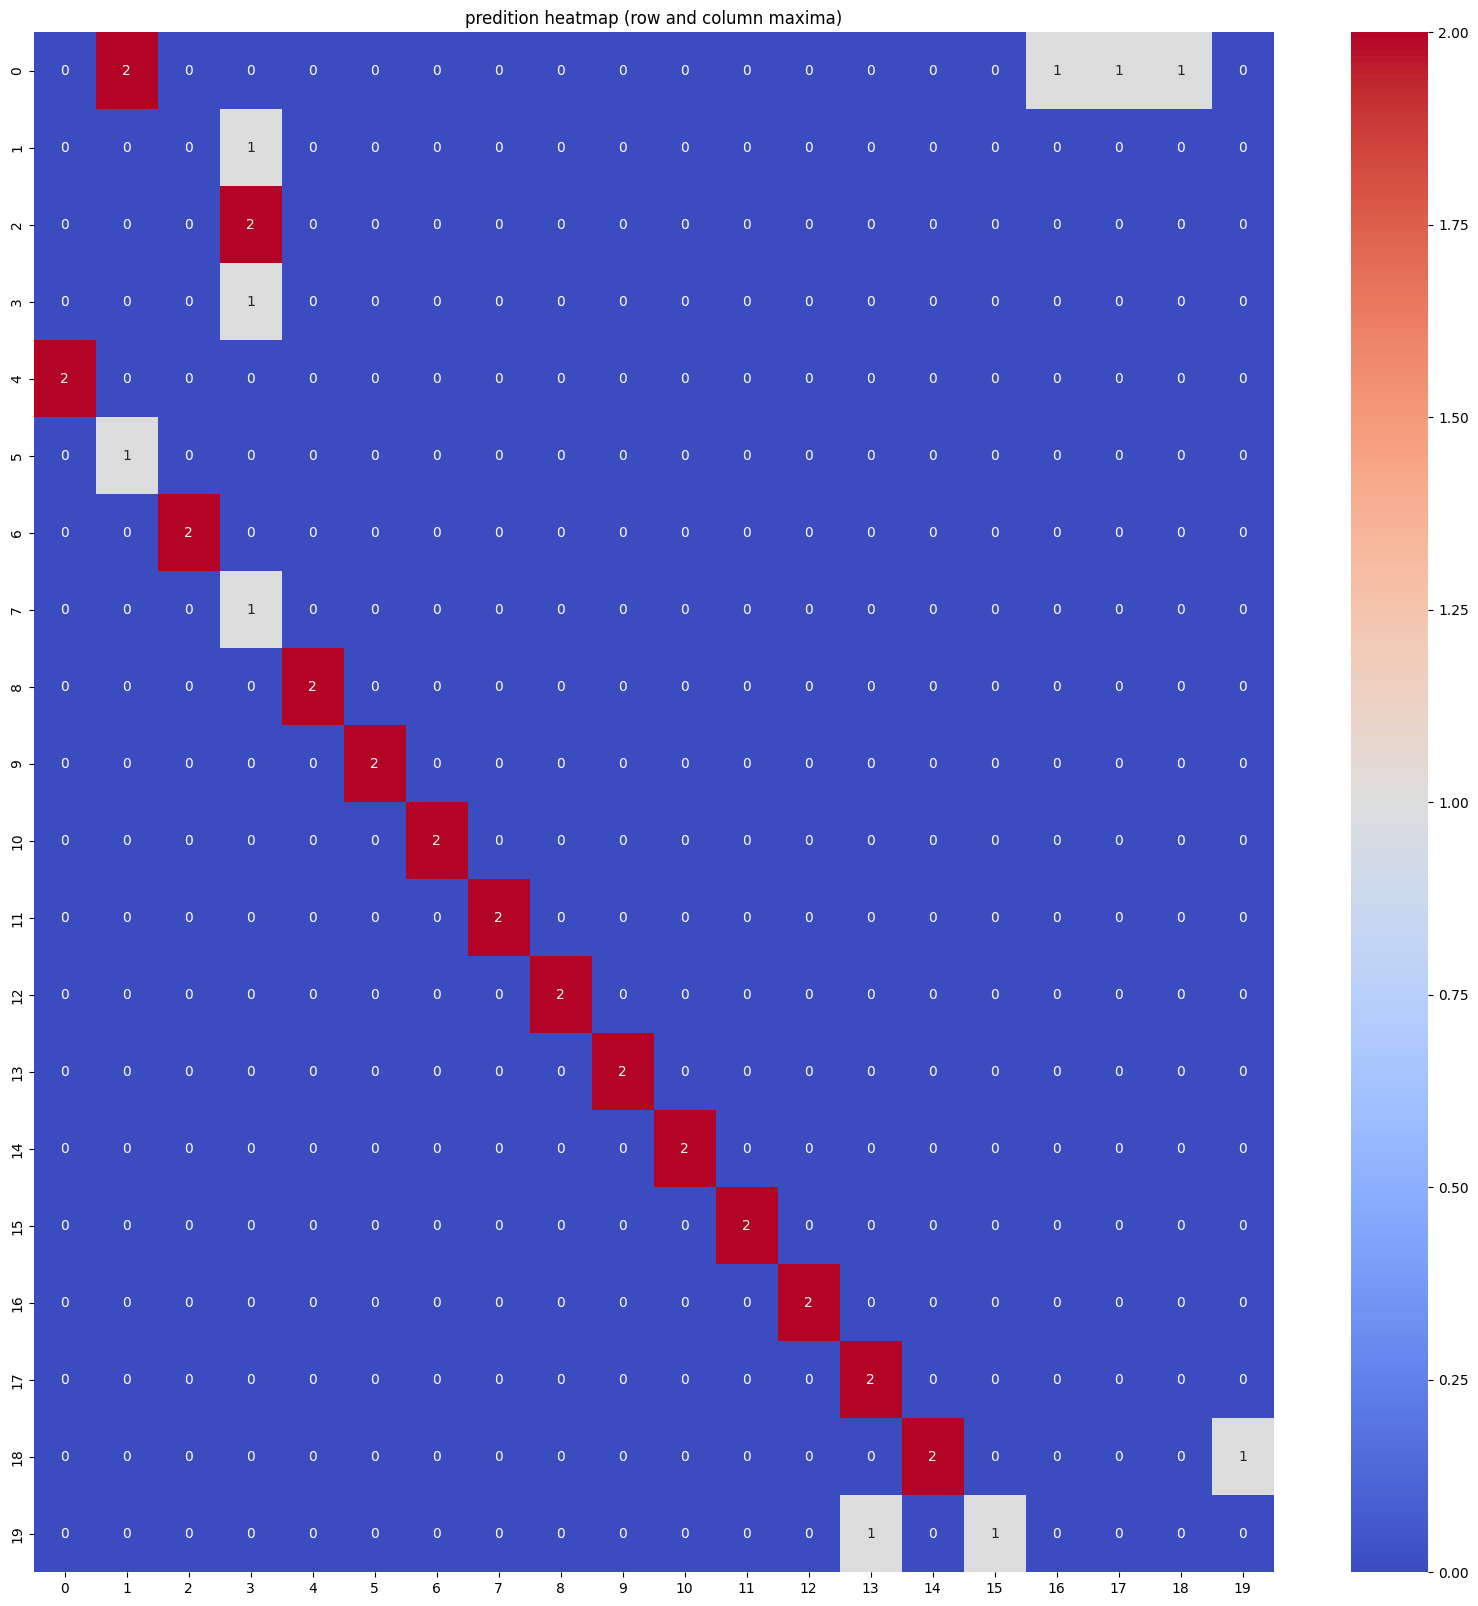

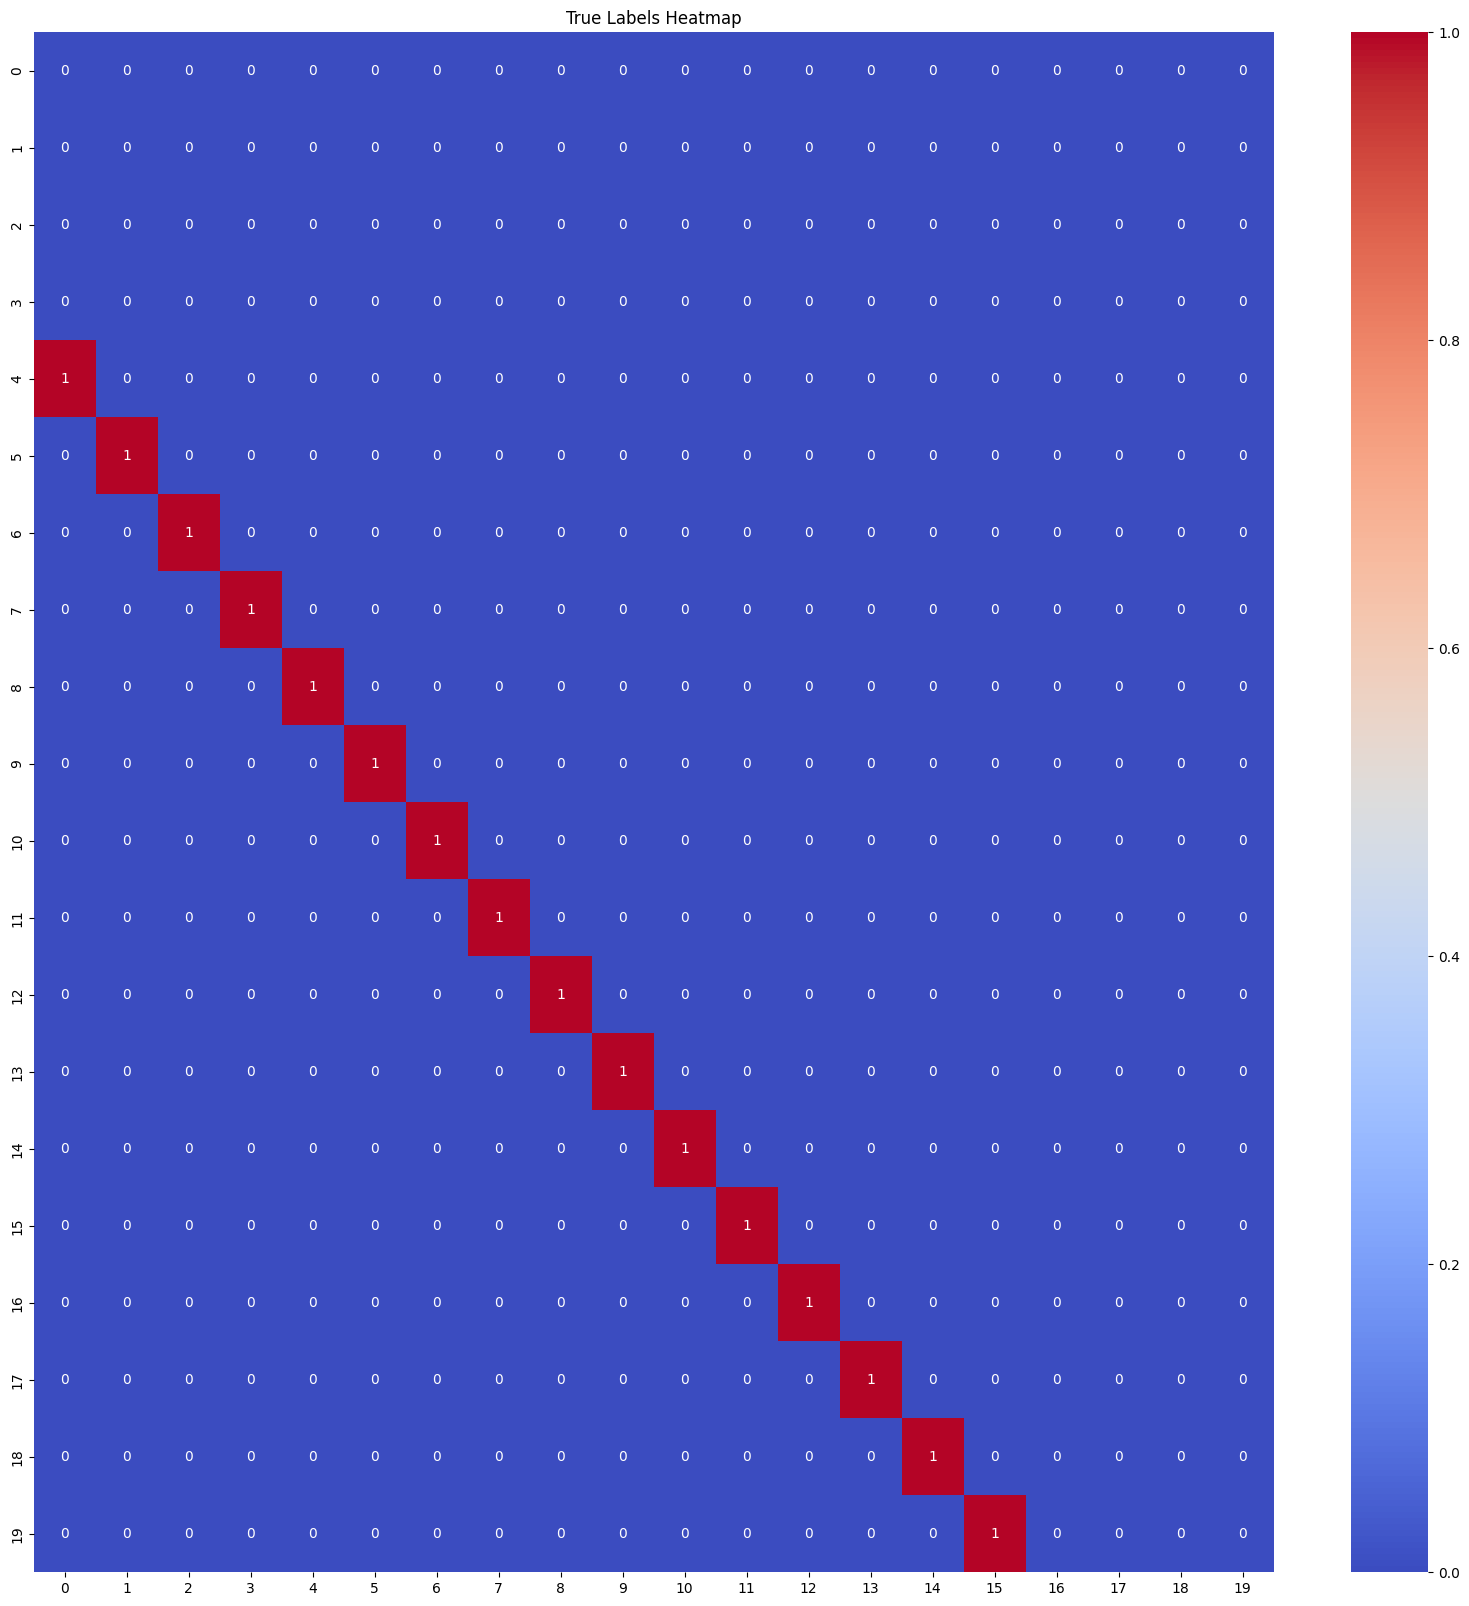

In [6]:
# Instantiate the model
num_heads = 4
embed_dim = 48
num_layers = 2
lr = 1e-3
weight_name = 'best_weights_org.h5'

print("Model Parameters:")
print(f"Number of heads: {num_heads}", f"Embedding dimension: {embed_dim}", f"Number of layers: {num_layers}", sep="\n")
print(f"Learning rate: {lr}", f"Weight name: {weight_name}", sep="\n")

model = TransformerModel(num_heads=num_heads, embed_dim=embed_dim, num_layers=num_layers)

feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"

# Train the model
model.train(
    feature_loc,
    batch_size=256,
    epochs=400,
    learning_rate=lr,
    weight_name= weight_name
)

### draft below

In [3]:
class PredictionCallback(Callback):
    def __init__(self, val_data):
        super(PredictionCallback, self).__init__()
        self.val_data = val_data
    
    def on_train_end(self, logs=None):
        # Take the first batch of validation samples at the end of training
        for batch in self.val_data.take(1):
            inputs, y_true = batch
            y_pred = self.model.predict(inputs)

            # Print final predictions and corresponding true values after training
            print("\nFinal predictions after training:")
            print("Predicted:\n", y_pred[0])
            print("True:\n", y_true[0])
            
            distance, heatmap = self.find_largest_diag(y_pred[0])
            # Plot the heatmap
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_pred[0], annot=True, cmap="coolwarm")
            plt.title(f'predition: {distance}')
            plt.show()

            plt.figure(figsize=(20, 20))
            sns.heatmap(heatmap, annot=True, cmap="coolwarm")
            plt.title('predition heatmap (row and column maxima)')
            plt.show()
            
            plt.figure(figsize=(20, 20))
            sns.heatmap(y_true[0], annot=True, cmap="coolwarm")
            plt.title('True Labels Heatmap')
            plt.show()
            
    def find_largest_diag(self, similarity_matrix):
        # Get matrix dimensions
        n = similarity_matrix.shape[0]

        # Convert to TensorFlow tensor
        sim_matrix = tf.constant(similarity_matrix, dtype=tf.float32)

        # Find the position of the maximum value in each row
        row_max_indices = []
        for i in range(n):
            row_idx = tf.argmax(sim_matrix[i, :])
            row_max_indices.append(tf.round(row_idx))  # Round the softargmax result to integer index
        row_max_indices = tf.stack(row_max_indices)
#         print("Row max indices (rounded):", row_max_indices)

        # Find the position of the maximum value in each column
        col_max_indices = []
        for i in range(n):
            col_idx = tf.argmax(sim_matrix[:, i])
            col_max_indices.append(tf.round(col_idx))  # Similarly, round each column result
        col_max_indices = tf.stack(col_max_indices)
#         print("Column max indices (rounded):", col_max_indices)

        # Create a heatmap to mark the maximum values
        heatmap = np.zeros_like(similarity_matrix)
        for i in range(n):
            row_idx = int(row_max_indices[i].numpy())
            col_idx = int(col_max_indices[i].numpy())

            # Ensure indices are within matrix dimensions
            if 0 <= row_idx < n:
                heatmap[i, row_idx] += 1  # Mark the maximum value in each row
            if 0 <= col_idx < n:
                heatmap[col_idx, i] += 1  # Mark the maximum value in each column

        # Find the diagonal with the most marks
        max_diag_marks = -1
        max_diag_idx = 0
        for diag_idx in range(-n+1, n):
            diag_marks = np.sum(np.diag(heatmap, k=diag_idx))
            if diag_marks > max_diag_marks:
                max_diag_marks = diag_marks
                max_diag_idx = diag_idx

        # Calculate the distance of the optimal diagonal from the center diagonal
        distance = max_diag_idx

        # Return the distance and the heatmap
        return distance, heatmap

In [4]:
def get_positional_encoding(seq_len, embed_dim):
    """
    Generates the positional encoding matrix for the input sequence.
    Args:
        seq_len (int): The length of the input sequence.
        embed_dim (int): The embedding dimension.
    Returns:
        tf.Tensor: A tensor containing positional encodings.
    """
    position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]  # Shape (seq_len, 1)
    div_term = tf.exp(tf.range(0, embed_dim, 2, dtype=tf.float32) * -(tf.math.log(10000.0) / embed_dim))  # Shape (embed_dim//2,)

    pos_enc = tf.zeros((seq_len, embed_dim))

    # Apply sin to even indices
    pos_enc = pos_enc + tf.concat([tf.sin(position * div_term), tf.cos(position * div_term)], axis=-1)

    return pos_enc

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, nhead):
        super(EncoderLayer, self).__init__()

        self.nhead = nhead

        self.q_proj = layers.Dense(d_model, use_bias=False)
        self.k_proj = layers.Dense(d_model, use_bias=False)
        self.v_proj = layers.Dense(d_model, use_bias=False)
        self.attention = layers.MultiHeadAttention(num_heads=self.nhead, key_dim=d_model)  
        self.merge = layers.Dense(d_model, use_bias=False)

        # feed-forward network
        self.mlp = tf.keras.Sequential([
            layers.Dense(d_model * 2, use_bias=False),
            layers.ReLU(),
            layers.Dense(d_model, use_bias=False)
        ])

        # norm layers
        self.norm1 = layers.LayerNormalization()
        self.norm2 = layers.LayerNormalization()

    def call(self, x, source):
        
        # multi-head attention
        query = self.q_proj(x)  
        key = self.k_proj(source)  
        value = self.v_proj(source)  

        message = self.attention(query=query, key=key, value=value)  
        message = self.merge(message)  
        message = self.norm1(message)

        # feed-forward network
        message = self.mlp(tf.concat([x, message], axis=-1)) 
        message = self.norm2(message)

        return x + message

In [5]:
class TransformerModel(tf.keras.Model):
    def __init__(self, num_heads=4,embed_dim=48, num_layers=2):
        super(TransformerModel, self).__init__()
        self.num_layers = num_layers
        self.embed_dim = embed_dim

        # Transformer Encoder layers (Now using cross-attention)
        self.encoder_layers = [
            EncoderLayer(d_model = embed_dim, nhead = num_heads)
            for _ in range(num_layers*2)
        ]
        
        self.multiHeadattention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=self.embed_dim)
        
    def call(self, inputs, training=True):
        query = inputs['query']
        context = inputs['context']
        batch_size = tf.shape(query)[0]
        seq_len = tf.shape(query)[1]
        
        # Incorporate positional encoding
        self.positional_encoding = get_positional_encoding(seq_len, self.embed_dim)
        
        # Add positional encoding to query and context after concatenating the class token
        query += self.positional_encoding[:seq_len, :]  # Adding positional encoding for sequence
        context += self.positional_encoding[:seq_len, :]

        # Pass through transformer encoder layers using cross-attention
        for i,encoder_layer in enumerate(self.encoder_layers):
            if i % 2 == 0:
                # self-attention
                query = encoder_layer(query,query)
                context  = encoder_layer(context,context)
                
            else:
                # cross-attention
                query = encoder_layer(query,context)
                context = encoder_layer(context,query)
            
        
        _, attention_scores = self.multiHeadattention(query=query, key=context, value=context, 
                                                      return_attention_scores=True)
        
        similarity_matrix = tf.reduce_mean(attention_scores, axis=1)
        
        return similarity_matrix
    
    def train(self, pathSimilarityVectorsArray: str , batch_size = 256, epochs=100, learning_rate=1e-3, weight_name = ""):
        """
        Args:
            train_dataset (tf.data.Dataset): Training dataset.
            val_dataset (tf.data.Dataset): Validation dataset.
            epochs (int): Number of epochs to train for.
            learning_rate (float): Learning rate for the optimizer.
            train_steps_per_epoch (int): Number of training steps per epoch.
            val_steps_per_epoch (int): Number of validation steps per epoch.
        """
        def create_diag_matrix(y, sequence_length):
            matrix = np.zeros((sequence_length, sequence_length), dtype=np.float32)
            diag_offset = int(y)
            if -sequence_length < diag_offset < sequence_length:
                effective_length = max(0, sequence_length - abs(diag_offset))  
                if effective_length > 0:
                    np.fill_diagonal(matrix[max(0, -diag_offset):, max(0, diag_offset):], 1)
            return matrix

        def map_fn(features, y_label):
            sequence_length = 20
            diag_matrix = tf.py_function(func=create_diag_matrix, inp=[y_label, sequence_length], Tout=tf.float32)
            diag_matrix.set_shape((sequence_length, sequence_length)) 
            return features, diag_matrix
        
        trainDS = np.load(fr"{pathSimilarityVectorsArray}",allow_pickle=True) 
        
        # Extracting the features and labels from the training dataset
        left_features = trainDS[:, 0].tolist()
        right_features = trainDS[:, 1].tolist()
        y = trainDS[:, 4].tolist()

        # Convert lists to numpy arrays and then to tensors
        left_features = np.array(left_features)
        right_features = np.array(right_features)
        y = np.array(y).astype(np.float32)

        left_features = tf.convert_to_tensor(left_features, dtype=tf.float32)
        right_features = tf.convert_to_tensor(right_features, dtype=tf.float32)

        # Split the dataset into training and validation sets
        size = int(len(y) * 0.8)  # Use 80% of the data for training
        left_features_train, left_features_val = left_features[:size], left_features[size:]
        right_features_train, right_features_val = right_features[:size], right_features[size:]
        y_train, y_val = y[:size], y[size:]

        # Creating TensorFlow datasets without preprocessing labels in advance
        train_dataset = tf.data.Dataset.from_tensor_slices(({'query': left_features_train, 'context': right_features_train}, y_train))
        train_dataset = train_dataset.shuffle(buffer_size=1024)

        # Use a map function to convert y to diagonal matrices
        train_dataset = train_dataset.map(map_fn).batch(batch_size,drop_remainder=True).repeat()

        # Construct the validation dataset
        val_dataset = tf.data.Dataset.from_tensor_slices(({'query': left_features_val, 'context': right_features_val}, y_val))
        val_dataset = val_dataset.map(map_fn).batch(32,drop_remainder=True)

        # Calculate the number of training and validation steps per epoch
        train_steps_per_epoch = len(left_features_train) // batch_size
        val_steps_per_epoch = len(left_features_val) // 32
        
                # Add ModelCheckpoint to save only the weights of the best model
        checkpoint_callback = ModelCheckpoint(
            weight_name,  # Save only the model weights
            monitor='val_loss',  # Monitor validation accuracy
            save_best_only=True,     # Save only if the validation accuracy improves
            mode='min',              # We want to maximize the validation accuracy
            save_weights_only=True,  # Save only the weights, not the entire model
            verbose=1
        )        

        # Compile the model using the custom loss function
        optimizer = Adam(learning_rate=1e-3)
        self.compile(optimizer=optimizer, loss=self.rows_cols_crossentropyLoss)

        # Train the model with the specified datasets, number of epochs, and callbacks
        model.fit(
            train_dataset,
            epochs=epochs,
            steps_per_epoch=train_steps_per_epoch,
            validation_data=val_dataset,
            validation_steps=val_steps_per_epoch,
            callbacks=[checkpoint_callback, PredictionCallback(val_dataset)]
        )
        
        # Load the best model weights at the end of training
        self.load_weights(weight_name)
        
    def rows_cols_crossentropyLoss(self, y_true, y_pred):
        # Row-wise softmax
        y_pred_row_softmax = tf.nn.softmax(y_pred, axis=-1)  # Softmax along rows (axis=-1)
        # Column-wise softmax
        y_pred_col_softmax = tf.nn.softmax(y_pred, axis=-2)  # Softmax along columns (axis=-2)

        # Generate row mask (if a row in y_true is all zeros, mask it out)
        row_mask = tf.reduce_sum(y_true, axis=-1) > 0  # Shape: (batch_size, seq_len)
        row_mask = tf.cast(row_mask, dtype=tf.float32)  # Convert bool mask to float (1s and 0s)

        # Row-wise cross-entropy loss (batch-wise operation)
        row_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred_row_softmax)
        row_loss = row_loss * row_mask  # Apply the mask to the row loss

        # Transpose y_true and y_pred for column-wise loss (only last two dimensions)
        y_true_transposed = tf.transpose(y_true, perm=[0, 2, 1])  # Swap last two dimensions for batched input
        y_pred_col_softmax_transposed = tf.transpose(y_pred_col_softmax, perm=[0, 2, 1])

        # Generate column mask (if a column in y_true is all zeros, mask it out)
        col_mask = tf.reduce_sum(y_true, axis=-2) > 0  # Shape: (batch_size, seq_len)
        col_mask = tf.cast(col_mask, dtype=tf.float32)  # Convert bool mask to float (1s and 0s)

        # Column-wise cross-entropy loss
        col_loss = tf.keras.losses.categorical_crossentropy(y_true_transposed, y_pred_col_softmax_transposed)
        col_loss = col_loss * col_mask  # Apply the mask to the column loss

        # Final loss is the average of row and column losses (only summing valid rows and columns)
        total_loss = (tf.reduce_sum(row_loss) + tf.reduce_sum(col_loss)) / (tf.reduce_sum(row_mask) + tf.reduce_sum(col_mask))

        return total_loss
        

2024-10-01 08:03:49.832433: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-01 08:03:49.853859: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-01 08:03:49.854145: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-10-01 08:03:49.856496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Epoch 1/500
 1/93 [..............................] - ETA: 7:54 - loss: 2.9957

2024-10-01 08:03:56.323409: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401


93/93 [==============================] - ETA: 0s - loss: 2.9956
Epoch 1: val_loss improved from inf to 2.99480, saving model to best_weights_1.h5
93/93 [==============================] - 49s 479ms/step - loss: 2.9956 - val_loss: 2.9948
Epoch 2/500
93/93 [==============================] - ETA: 0s - loss: 2.9659
Epoch 2: val_loss improved from 2.99480 to 2.94033, saving model to best_weights_1.h5
93/93 [==============================] - 43s 459ms/step - loss: 2.9659 - val_loss: 2.9403
Epoch 3/500
93/93 [==============================] - ETA: 0s - loss: 2.9348
Epoch 3: val_loss improved from 2.94033 to 2.92542, saving model to best_weights_1.h5
93/93 [==============================] - 45s 480ms/step - loss: 2.9348 - val_loss: 2.9254
Epoch 4/500
93/93 [==============================] - ETA: 0s - loss: 2.9215
Epoch 4: val_loss improved from 2.92542 to 2.92123, saving model to best_weights_1.h5
93/93 [==============================] - 45s 487ms/step - loss: 2.9215 - val_loss: 2.9212
Epoch 5/

Epoch 34/500
93/93 [==============================] - ETA: 0s - loss: 2.4503
Epoch 34: val_loss improved from 2.46397 to 2.45879, saving model to best_weights_1.h5
93/93 [==============================] - 46s 492ms/step - loss: 2.4503 - val_loss: 2.4588
Epoch 35/500
93/93 [==============================] - ETA: 0s - loss: 2.4484
Epoch 35: val_loss did not improve from 2.45879
93/93 [==============================] - 45s 489ms/step - loss: 2.4484 - val_loss: 2.4629
Epoch 36/500
93/93 [==============================] - ETA: 0s - loss: 2.4418
Epoch 36: val_loss improved from 2.45879 to 2.45132, saving model to best_weights_1.h5
93/93 [==============================] - 45s 487ms/step - loss: 2.4418 - val_loss: 2.4513
Epoch 37/500
93/93 [==============================] - ETA: 0s - loss: 2.4378
Epoch 37: val_loss improved from 2.45132 to 2.44158, saving model to best_weights_1.h5
93/93 [==============================] - 45s 488ms/step - loss: 2.4378 - val_loss: 2.4416
Epoch 38/500
93/93 [===

Epoch 104/500
93/93 [==============================] - ETA: 0s - loss: 2.2545
Epoch 104: val_loss improved from 2.26195 to 2.25942, saving model to best_weights_1.h5
93/93 [==============================] - 45s 489ms/step - loss: 2.2545 - val_loss: 2.2594
Epoch 105/500
93/93 [==============================] - ETA: 0s - loss: 2.2472
Epoch 105: val_loss did not improve from 2.25942
93/93 [==============================] - 46s 492ms/step - loss: 2.2472 - val_loss: 2.2599
Epoch 106/500
93/93 [==============================] - ETA: 0s - loss: 2.2434
Epoch 106: val_loss improved from 2.25942 to 2.25915, saving model to best_weights_1.h5
93/93 [==============================] - 46s 492ms/step - loss: 2.2434 - val_loss: 2.2591
Epoch 107/500
93/93 [==============================] - ETA: 0s - loss: 2.2446
Epoch 107: val_loss improved from 2.25915 to 2.25817, saving model to best_weights_1.h5
93/93 [==============================] - 46s 490ms/step - loss: 2.2446 - val_loss: 2.2582
Epoch 108/500
9

Epoch 139/500
93/93 [==============================] - ETA: 0s - loss: 2.2264
Epoch 139: val_loss did not improve from 2.23356
93/93 [==============================] - 46s 492ms/step - loss: 2.2264 - val_loss: 2.2402
Epoch 140/500
93/93 [==============================] - ETA: 0s - loss: 2.2268
Epoch 140: val_loss did not improve from 2.23356
93/93 [==============================] - 46s 493ms/step - loss: 2.2268 - val_loss: 2.2404
Epoch 141/500
93/93 [==============================] - ETA: 0s - loss: 2.2208
Epoch 141: val_loss did not improve from 2.23356
93/93 [==============================] - 46s 490ms/step - loss: 2.2208 - val_loss: 2.2355
Epoch 142/500
93/93 [==============================] - ETA: 0s - loss: 2.2265
Epoch 142: val_loss did not improve from 2.23356
93/93 [==============================] - 45s 488ms/step - loss: 2.2265 - val_loss: 2.2338
Epoch 143/500
93/93 [==============================] - ETA: 0s - loss: 2.2218
Epoch 143: val_loss did not improve from 2.23356
93/93

93/93 [==============================] - 46s 494ms/step - loss: 2.2125 - val_loss: 2.2315
Epoch 176/500
93/93 [==============================] - ETA: 0s - loss: 2.2069
Epoch 176: val_loss did not improve from 2.21710
93/93 [==============================] - 46s 498ms/step - loss: 2.2069 - val_loss: 2.2235
Epoch 177/500
93/93 [==============================] - ETA: 0s - loss: 2.2120
Epoch 177: val_loss did not improve from 2.21710
93/93 [==============================] - 46s 493ms/step - loss: 2.2120 - val_loss: 2.2297
Epoch 178/500
93/93 [==============================] - ETA: 0s - loss: 2.2089
Epoch 178: val_loss did not improve from 2.21710
93/93 [==============================] - 46s 490ms/step - loss: 2.2089 - val_loss: 2.2189
Epoch 179/500
93/93 [==============================] - ETA: 0s - loss: 2.2058
Epoch 179: val_loss did not improve from 2.21710
93/93 [==============================] - 46s 496ms/step - loss: 2.2058 - val_loss: 2.2212
Epoch 180/500
93/93 [=====================

Epoch 213/500
93/93 [==============================] - ETA: 0s - loss: 2.1987
Epoch 213: val_loss did not improve from 2.20957
93/93 [==============================] - 46s 497ms/step - loss: 2.1987 - val_loss: 2.2132
Epoch 214/500
93/93 [==============================] - ETA: 0s - loss: 2.2033
Epoch 214: val_loss did not improve from 2.20957
93/93 [==============================] - 46s 492ms/step - loss: 2.2033 - val_loss: 2.2205
Epoch 215/500
93/93 [==============================] - ETA: 0s - loss: 2.2049
Epoch 215: val_loss did not improve from 2.20957
93/93 [==============================] - 46s 498ms/step - loss: 2.2049 - val_loss: 2.2158
Epoch 216/500
93/93 [==============================] - ETA: 0s - loss: 2.2027
Epoch 216: val_loss did not improve from 2.20957
93/93 [==============================] - 46s 493ms/step - loss: 2.2027 - val_loss: 2.2152
Epoch 217/500
93/93 [==============================] - ETA: 0s - loss: 2.2027
Epoch 217: val_loss did not improve from 2.20957
93/93

93/93 [==============================] - 46s 495ms/step - loss: 2.1862 - val_loss: 2.2021
Epoch 250/500
93/93 [==============================] - ETA: 0s - loss: 2.1809
Epoch 250: val_loss improved from 2.19684 to 2.19582, saving model to best_weights_1.h5
93/93 [==============================] - 46s 498ms/step - loss: 2.1809 - val_loss: 2.1958
Epoch 251/500
93/93 [==============================] - ETA: 0s - loss: 2.1800
Epoch 251: val_loss improved from 2.19582 to 2.19372, saving model to best_weights_1.h5
93/93 [==============================] - 46s 498ms/step - loss: 2.1800 - val_loss: 2.1937
Epoch 252/500
93/93 [==============================] - ETA: 0s - loss: 2.2118
Epoch 252: val_loss did not improve from 2.19372
93/93 [==============================] - 46s 498ms/step - loss: 2.2118 - val_loss: 2.2821
Epoch 253/500
93/93 [==============================] - ETA: 0s - loss: 2.2204
Epoch 253: val_loss did not improve from 2.19372
93/93 [==============================] - 46s 493ms/ste

93/93 [==============================] - ETA: 0s - loss: 2.1639
Epoch 285: val_loss improved from 2.18048 to 2.17827, saving model to best_weights_1.h5
93/93 [==============================] - 46s 493ms/step - loss: 2.1639 - val_loss: 2.1783
Epoch 286/500
93/93 [==============================] - ETA: 0s - loss: 2.1656
Epoch 286: val_loss did not improve from 2.17827
93/93 [==============================] - 46s 498ms/step - loss: 2.1656 - val_loss: 2.1843
Epoch 287/500
93/93 [==============================] - ETA: 0s - loss: 2.1658
Epoch 287: val_loss did not improve from 2.17827
93/93 [==============================] - 46s 496ms/step - loss: 2.1658 - val_loss: 2.1819
Epoch 288/500
93/93 [==============================] - ETA: 0s - loss: 2.1670
Epoch 288: val_loss did not improve from 2.17827
93/93 [==============================] - 46s 496ms/step - loss: 2.1670 - val_loss: 2.1883
Epoch 289/500
93/93 [==============================] - ETA: 0s - loss: 2.1707
Epoch 289: val_loss did not i

93/93 [==============================] - 46s 494ms/step - loss: 2.1482 - val_loss: 2.1780
Epoch 359/500
93/93 [==============================] - ETA: 0s - loss: 2.1526
Epoch 359: val_loss improved from 2.16509 to 2.16334, saving model to best_weights_1.h5
93/93 [==============================] - 46s 500ms/step - loss: 2.1526 - val_loss: 2.1633
Epoch 360/500
93/93 [==============================] - ETA: 0s - loss: 2.1463
Epoch 360: val_loss did not improve from 2.16334
93/93 [==============================] - 46s 495ms/step - loss: 2.1463 - val_loss: 2.1649
Epoch 361/500
93/93 [==============================] - ETA: 0s - loss: 2.1504
Epoch 361: val_loss did not improve from 2.16334
93/93 [==============================] - 46s 496ms/step - loss: 2.1504 - val_loss: 2.1681
Epoch 362/500
93/93 [==============================] - ETA: 0s - loss: 2.1458
Epoch 362: val_loss did not improve from 2.16334
93/93 [==============================] - 46s 500ms/step - loss: 2.1458 - val_loss: 2.1675
Epo

93/93 [==============================] - 46s 493ms/step - loss: 2.1410 - val_loss: 2.1638
Epoch 395/500
93/93 [==============================] - ETA: 0s - loss: 2.1381
Epoch 395: val_loss improved from 2.15185 to 2.15166, saving model to best_weights_1.h5
93/93 [==============================] - 46s 499ms/step - loss: 2.1381 - val_loss: 2.1517
Epoch 396/500
93/93 [==============================] - ETA: 0s - loss: 2.1338
Epoch 396: val_loss did not improve from 2.15166
93/93 [==============================] - 46s 493ms/step - loss: 2.1338 - val_loss: 2.1517
Epoch 397/500
93/93 [==============================] - ETA: 0s - loss: 2.1351
Epoch 397: val_loss did not improve from 2.15166
93/93 [==============================] - 46s 496ms/step - loss: 2.1351 - val_loss: 2.1530
Epoch 398/500
93/93 [==============================] - ETA: 0s - loss: 2.1326
Epoch 398: val_loss improved from 2.15166 to 2.14945, saving model to best_weights_1.h5
93/93 [==============================] - 46s 495ms/ste

Epoch 431/500
93/93 [==============================] - ETA: 0s - loss: 2.1261
Epoch 431: val_loss did not improve from 2.14297
93/93 [==============================] - 46s 495ms/step - loss: 2.1261 - val_loss: 2.1440
Epoch 432/500
93/93 [==============================] - ETA: 0s - loss: 2.1259
Epoch 432: val_loss did not improve from 2.14297
93/93 [==============================] - 46s 496ms/step - loss: 2.1259 - val_loss: 2.1444
Epoch 433/500
93/93 [==============================] - ETA: 0s - loss: 2.1279
Epoch 433: val_loss did not improve from 2.14297
93/93 [==============================] - 46s 498ms/step - loss: 2.1279 - val_loss: 2.1482
Epoch 434/500
93/93 [==============================] - ETA: 0s - loss: 2.1266
Epoch 434: val_loss did not improve from 2.14297
93/93 [==============================] - 46s 496ms/step - loss: 2.1266 - val_loss: 2.1445
Epoch 435/500
93/93 [==============================] - ETA: 0s - loss: 2.1260
Epoch 435: val_loss did not improve from 2.14297
93/93

Epoch 468/500
93/93 [==============================] - ETA: 0s - loss: 2.1248
Epoch 468: val_loss did not improve from 2.13854
93/93 [==============================] - 46s 498ms/step - loss: 2.1248 - val_loss: 2.1406
Epoch 469/500
93/93 [==============================] - ETA: 0s - loss: 2.1311
Epoch 469: val_loss did not improve from 2.13854
93/93 [==============================] - 46s 495ms/step - loss: 2.1311 - val_loss: 2.1875
Epoch 470/500
93/93 [==============================] - ETA: 0s - loss: 2.1404
Epoch 470: val_loss did not improve from 2.13854
93/93 [==============================] - 46s 496ms/step - loss: 2.1404 - val_loss: 2.1460
Epoch 471/500
93/93 [==============================] - ETA: 0s - loss: 2.1249
Epoch 471: val_loss did not improve from 2.13854
93/93 [==============================] - 46s 497ms/step - loss: 2.1249 - val_loss: 2.1416
Epoch 472/500
93/93 [==============================] - ETA: 0s - loss: 2.1221
Epoch 472: val_loss did not improve from 2.13854
93/93

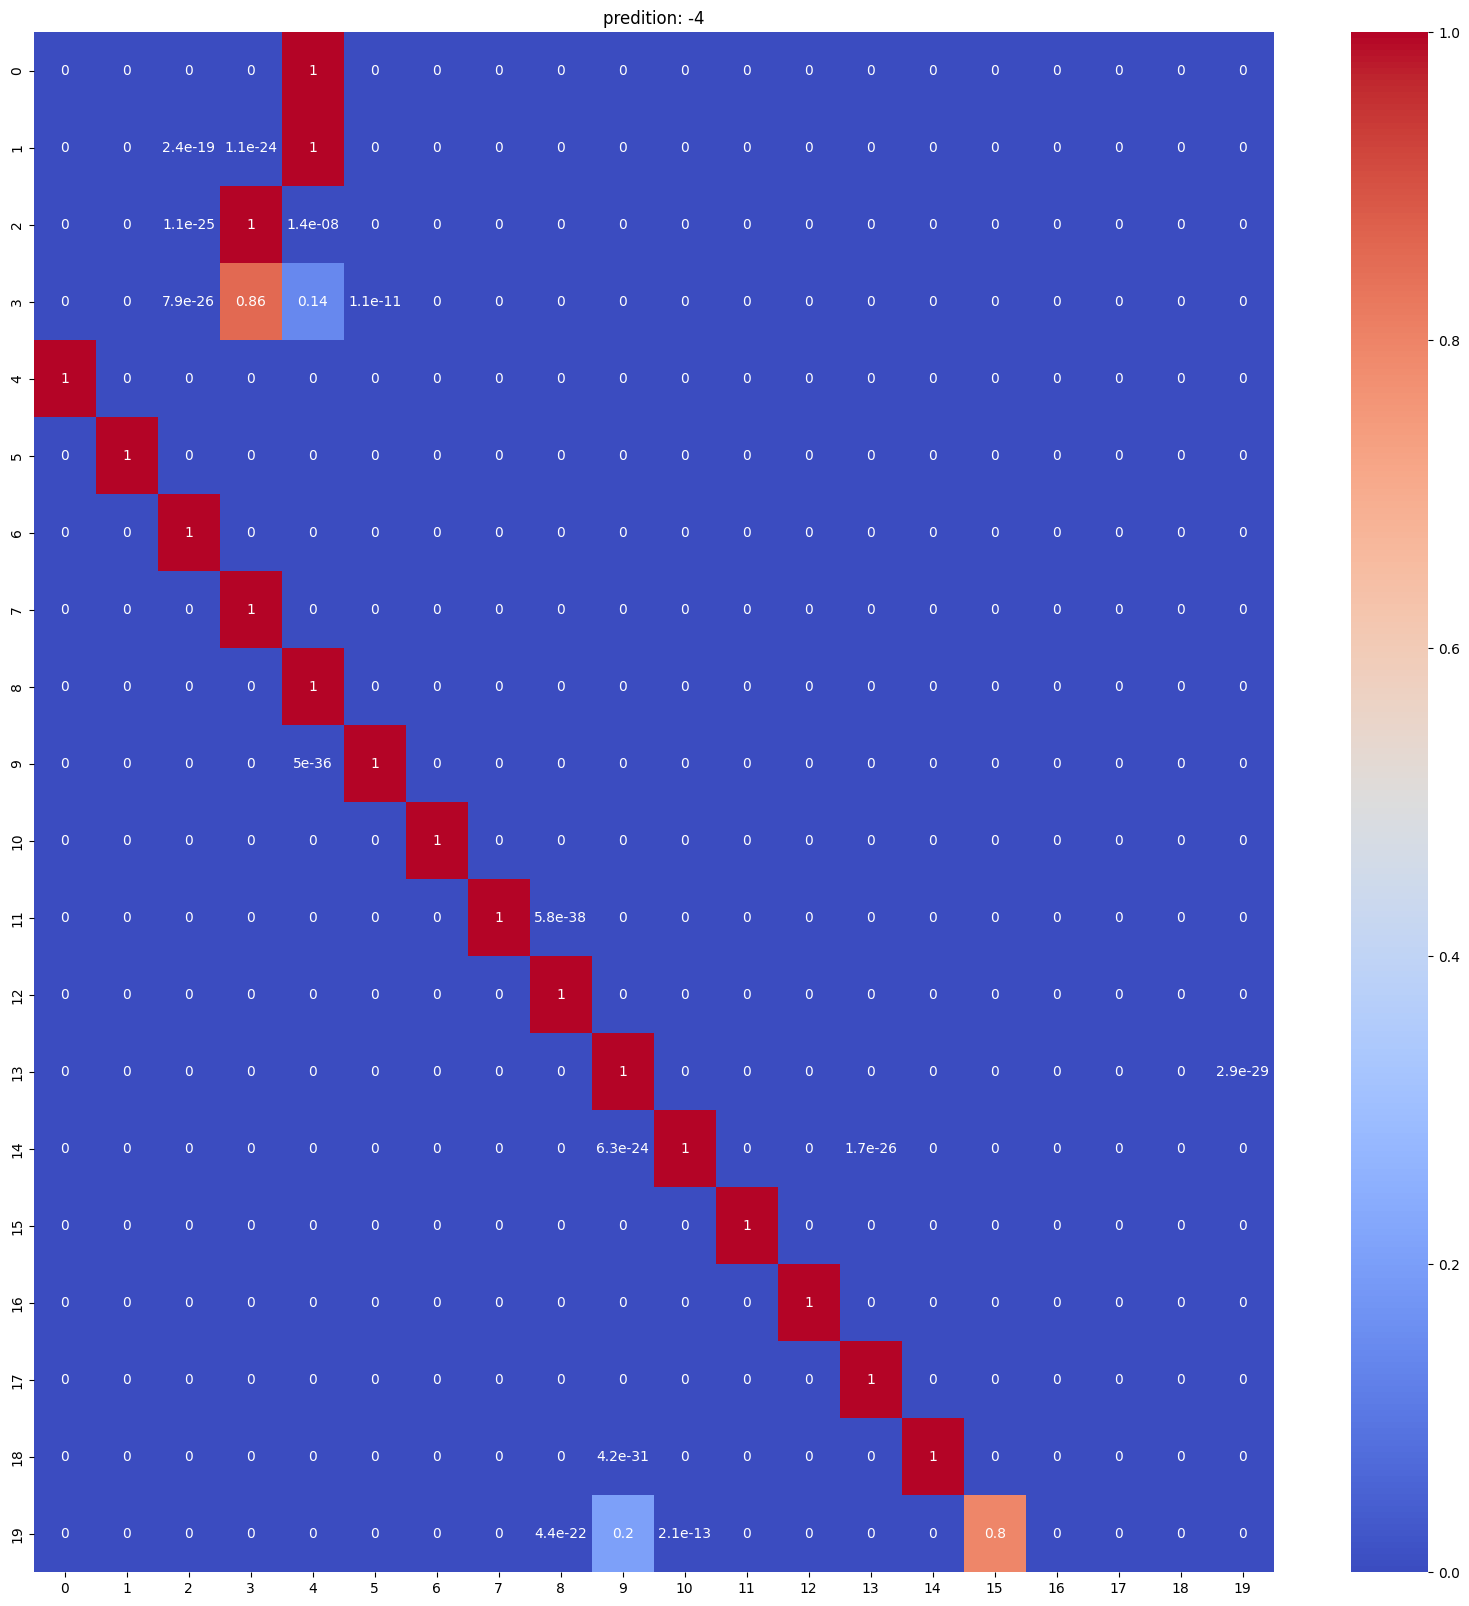

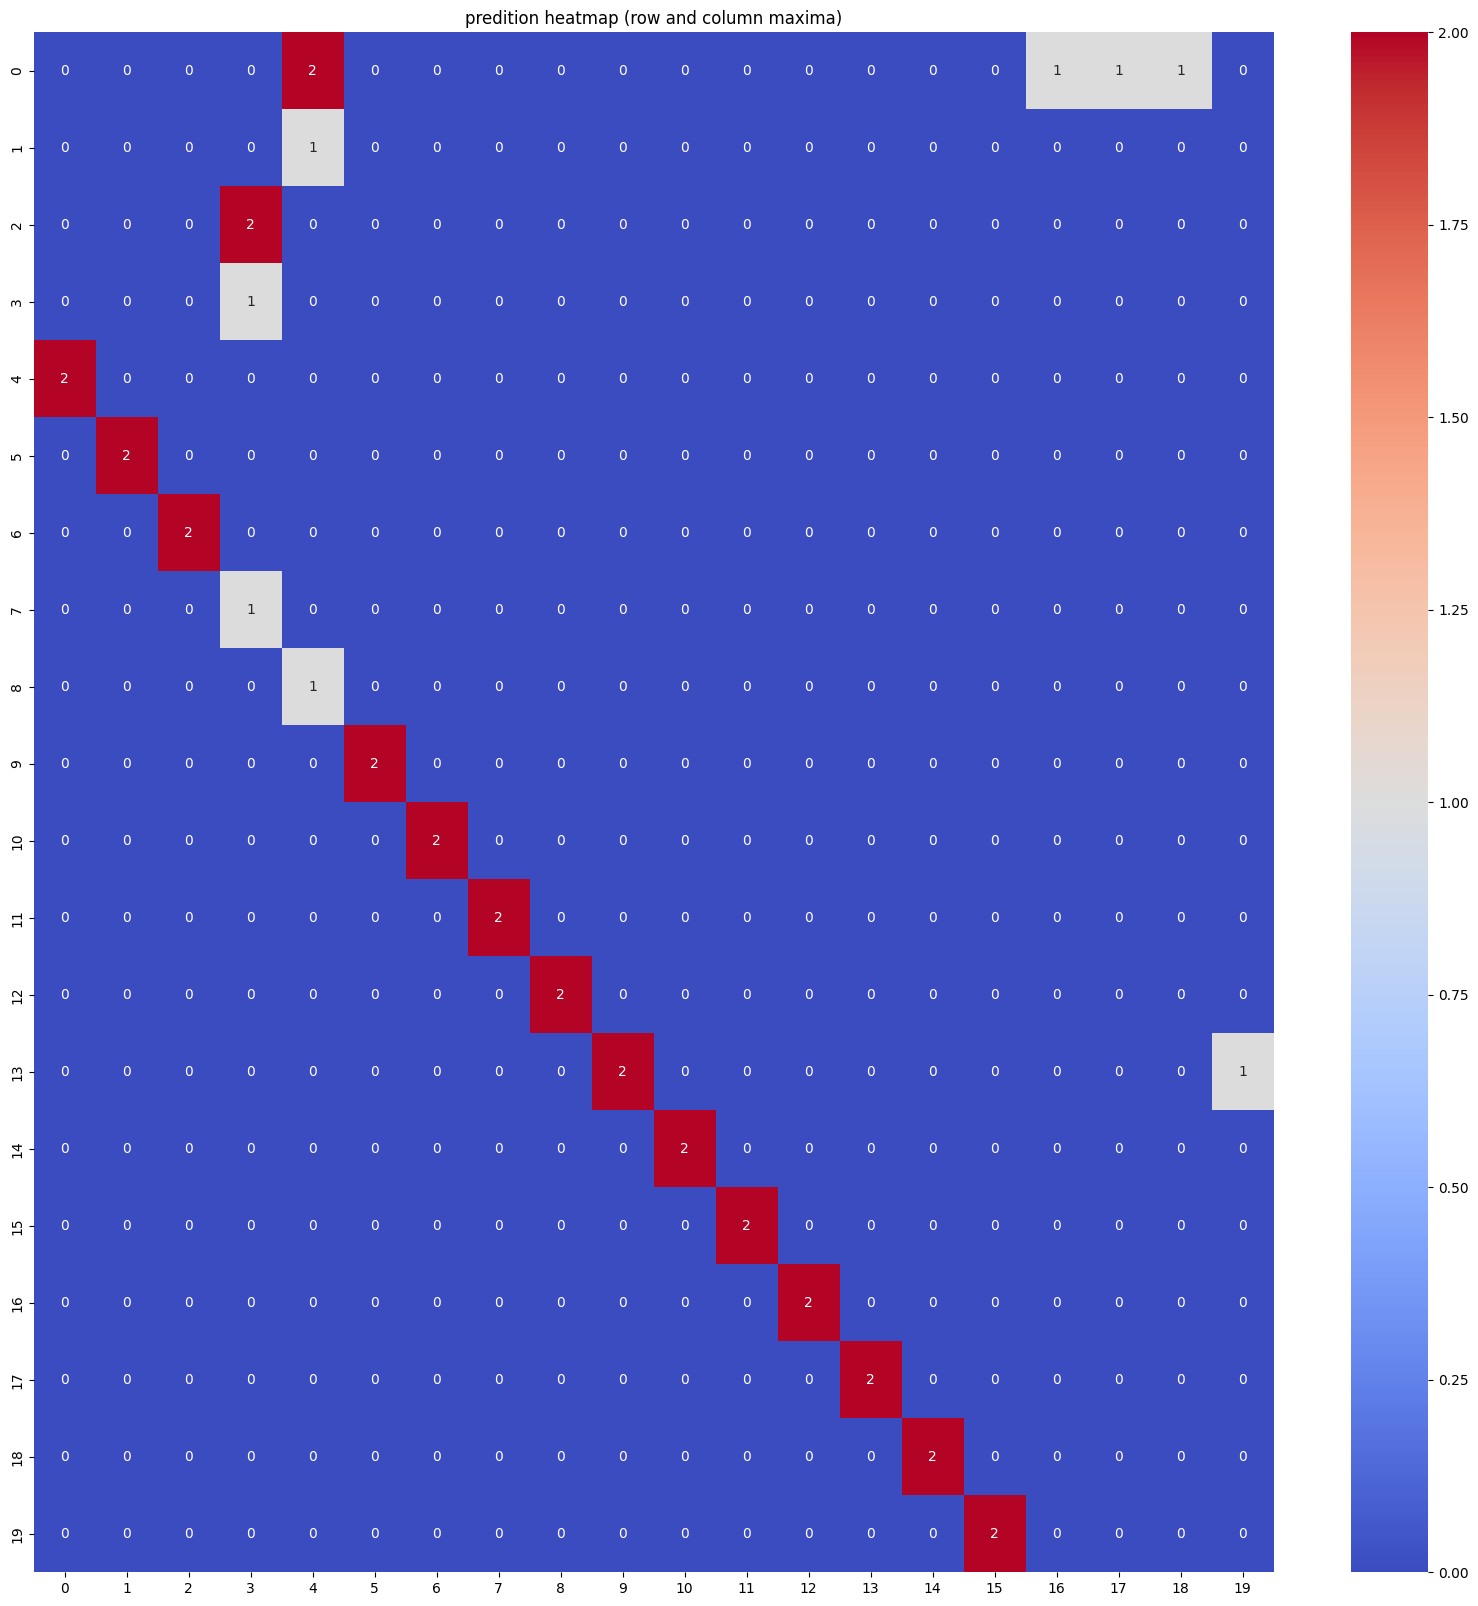

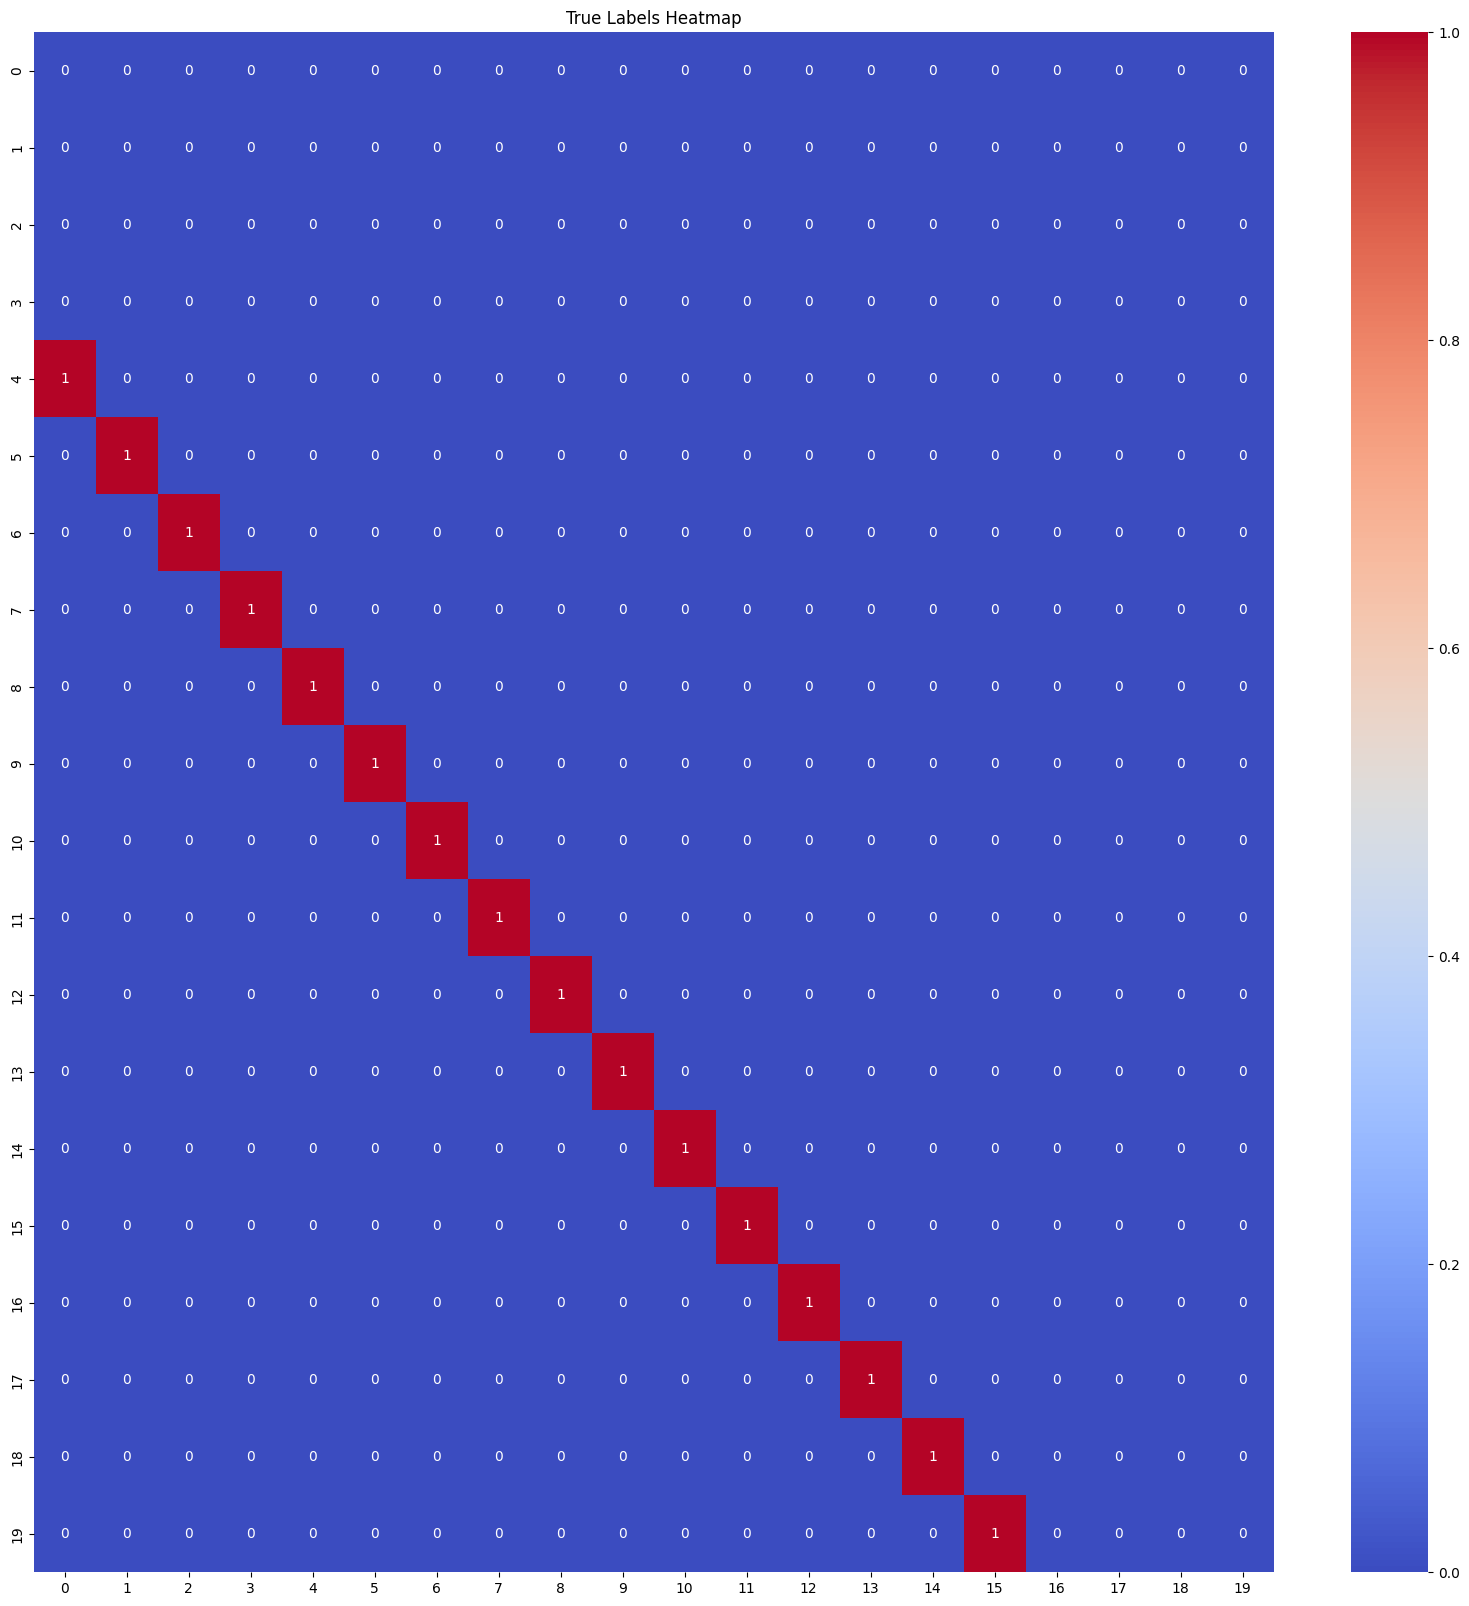

In [6]:
# Instantiate the model
model = TransformerModel(num_heads=4,embed_dim=48, num_layers=2)

feature_loc = "/home/jireh/MT/video_sync_v1/trash/featureData_21.npy"

# Train the model
model.train(
    feature_loc, 
    batch_size = 256, 
    epochs=500, 
    learning_rate=1e-3,
    weight_name = 'best_weights_1.h5'
)